In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Environment import Environment, ContextConfig
from ContextNode import ContextNode
from TS import TS
from UCB import UCB
from Solver import Solver

In [2]:
env = Environment()
solver = Solver(env)
optimal_configurations, optimal_rewards = solver.find_optimal()

"""
Should be:
UserType 0:   2, 0, 1, 2, 3  -> FF (class: 0) + FV (class: 1)
UserType 1:   3, 1, 3, 0, 2  -> VF (class: 2)
UserType 2:   0, 3, 1, 2, 0  -> VV (class: 3)
"""

print("OPTIMAL CONFIGURATION")
print(optimal_configurations)
print("OPTIMAL A-PRIORI REWARD")
print(optimal_rewards)

OPTIMAL CONFIGURATION
[[2 0 1 2 3]
 [3 1 3 0 2]
 [0 3 1 2 0]]
OPTIMAL A-PRIORI REWARD
[7.81830836 7.17302757 7.42556207]


In [3]:
runs = 20
T = 100
split_step = 14

ucb_results = []
ts_results = []
optimal_results = []

In [4]:
for r in range(runs):
    env.clear_history()

    ucb_rounds = []
    ts_rounds = []
    optimal_rounds = []
    learners = []

    ucb_root = ContextNode(env, UCB, feature_1=None, feature_2=None)
    ts_root = ContextNode(env, TS, feature_1=None, feature_2=None)

    ucb_splits = []
    ts_splits = []

    optimal_ctx_configs = [ContextConfig(config, [user_type, user_type + 1]) if user_type == 0
                           else ContextConfig(config, [user_type + 1])
                           for user_type, config in enumerate(optimal_configurations)]

    print("\n########## RUN", r+1, "\n")

    for i in range(T):
        seed = np.random.randint(1, 2 ** 30)

        ucb_leaves = ucb_root.get_leaves()
        if i > 0 and i % split_step == 0:
            for leaf in ucb_leaves:
                if leaf.split():
                    ucb_splits.append(i)
            ucb_leaves = ucb_root.get_leaves()
        ucb_learners = [leaf.learner for leaf in ucb_leaves]
        ucb_ctx_configs = [ContextConfig(ucb.pull(), ucb.agg_classes) for ucb in ucb_learners]
        ucb_round_data = env.round(ucb_ctx_configs, learner_class=UCB, seed=seed)
        ucb_rounds.append(ucb_round_data)
        for ucb_learner in ucb_learners:
            ucb_learner.update(ucb_round_data)

        ts_leaves = ts_root.get_leaves()
        if i > 0 and i % split_step == 0:
            for leaf in ts_leaves:
                if leaf.split():
                    ts_splits.append(i)
            ts_leaves = ts_root.get_leaves()
        ts_learners = [leaf.learner for leaf in ts_leaves]
        ts_ctx_configs = [ContextConfig(ts.pull(), ts.agg_classes) for ts in ts_learners]
        ts_round_data = env.round(ts_ctx_configs, learner_class=TS, seed=seed)
        ts_rounds.append(ts_round_data)
        for ts_learner in ts_learners:
            ts_learner.update(ts_round_data)

        optimal_round_data = env.round(optimal_ctx_configs, seed=seed)
        optimal_rounds.append(optimal_round_data)

    ucb_rewards = np.array([np.zeros(T) for _ in range(env.n_user_types)])
    ts_rewards = np.array([np.zeros(T) for _ in range(env.n_user_types)])
    optimal_rewards = np.array([np.zeros(T) for _ in range(env.n_user_types)])

    for user_type in range(env.n_user_types):
        for i in range(T):
            ucb_rewards[user_type][i] = ucb_rounds[i].rewards[user_type]
            ts_rewards[user_type][i] = ts_rounds[i].rewards[user_type]
            optimal_rewards[user_type][i] = optimal_rounds[i].rewards[user_type]

    print("--------------------UCB---------------------")
    print("AVERAGE REWARD:")
    print("\t", np.average(ucb_rewards))
    print("AVERAGE REGRET:")
    print("\t", np.average(optimal_rewards - ucb_rewards))

    print("--------------------TS----------------------")
    print("AVERAGE REWARD:")
    print("\t", np.average(ts_rewards))
    print("AVERAGE REGRET:")
    print("\t", np.average(optimal_rewards - ts_rewards))

    ucb_results.append(ucb_rewards)
    ts_results.append(ts_rewards)
    optimal_results.append(optimal_rewards)


########## RUN 1 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.5714994294914604
AVERAGE REGRET:
	 0.4219115568344714
--------------------TS----------------------
AVERAGE REWARD:
	 3.7863097790052174
AVERAGE REGRET:
	 0.20710120732071347

########## RUN 2 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.5771325487436427
AVERAGE REGRET:
	 0.39112941750783353
--------------------TS----------------------
AVERAGE REWARD:
	 3.7737699967215907
AVERAGE REGRET:
	 0.1944919695298854

########## RUN 3 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.602598700404073
AVERAGE REGRET:
	 0.3938400550844321
--------------------TS----------------------
AVERAGE REWARD:
	 3.8145716827217453
AVERAGE REGRET:
	 0.18186707276675912

########## RUN 4 

--------------------UCB---------------------
AVERAGE REWARD:
	 3.538330272276256
AVERAGE REGRET:
	 0.42621180500940237
--------------------TS----------------------
AVERAGE REWARD:
	 3.743099185292168
AVER

In [5]:
ucb_results = np.array(ucb_results)
ts_results = np.array(ts_results)
optimal_results = np.array(optimal_results)

rounds = list(range(T))

In [6]:
ucb_rewards = ucb_results[0]
ts_rewards = ts_results[0]
optimal_rewards = optimal_results[0]

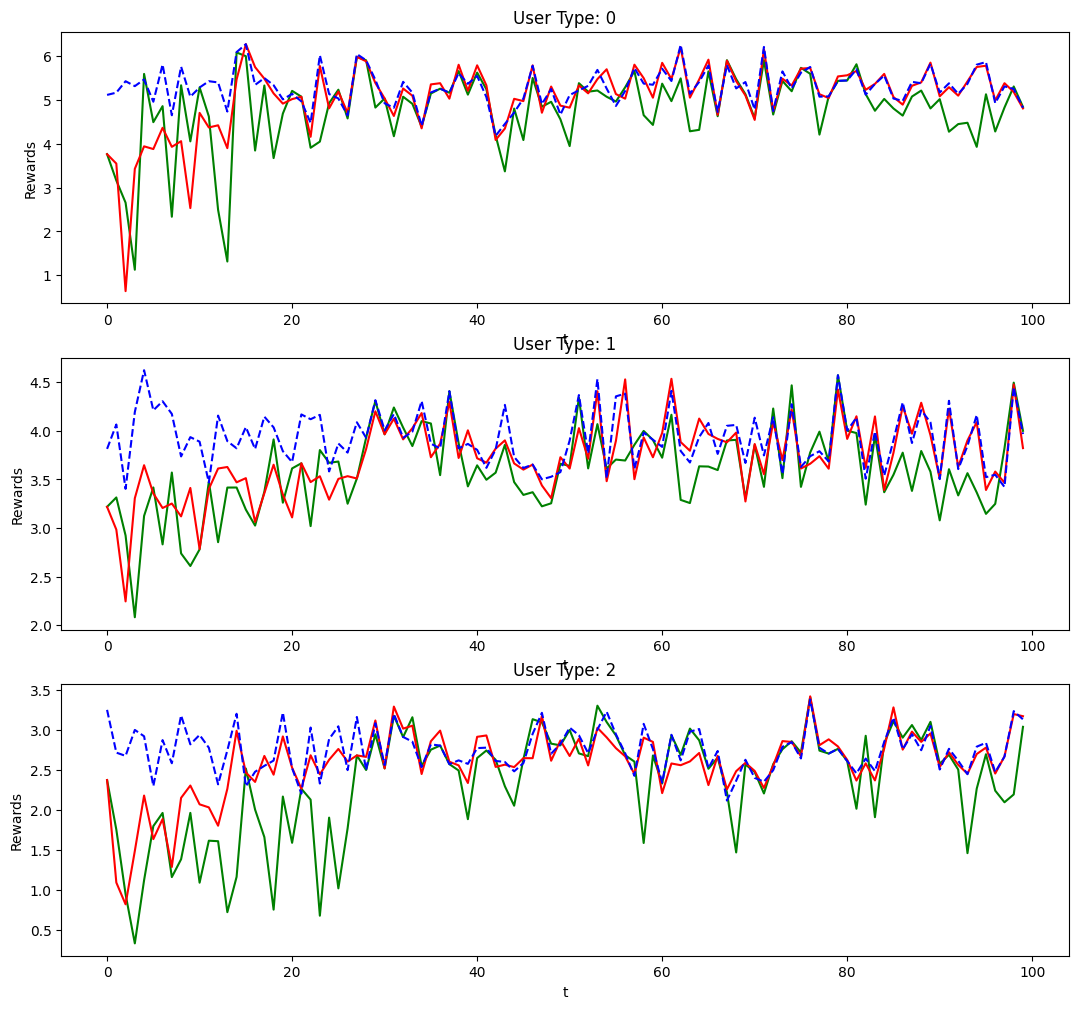

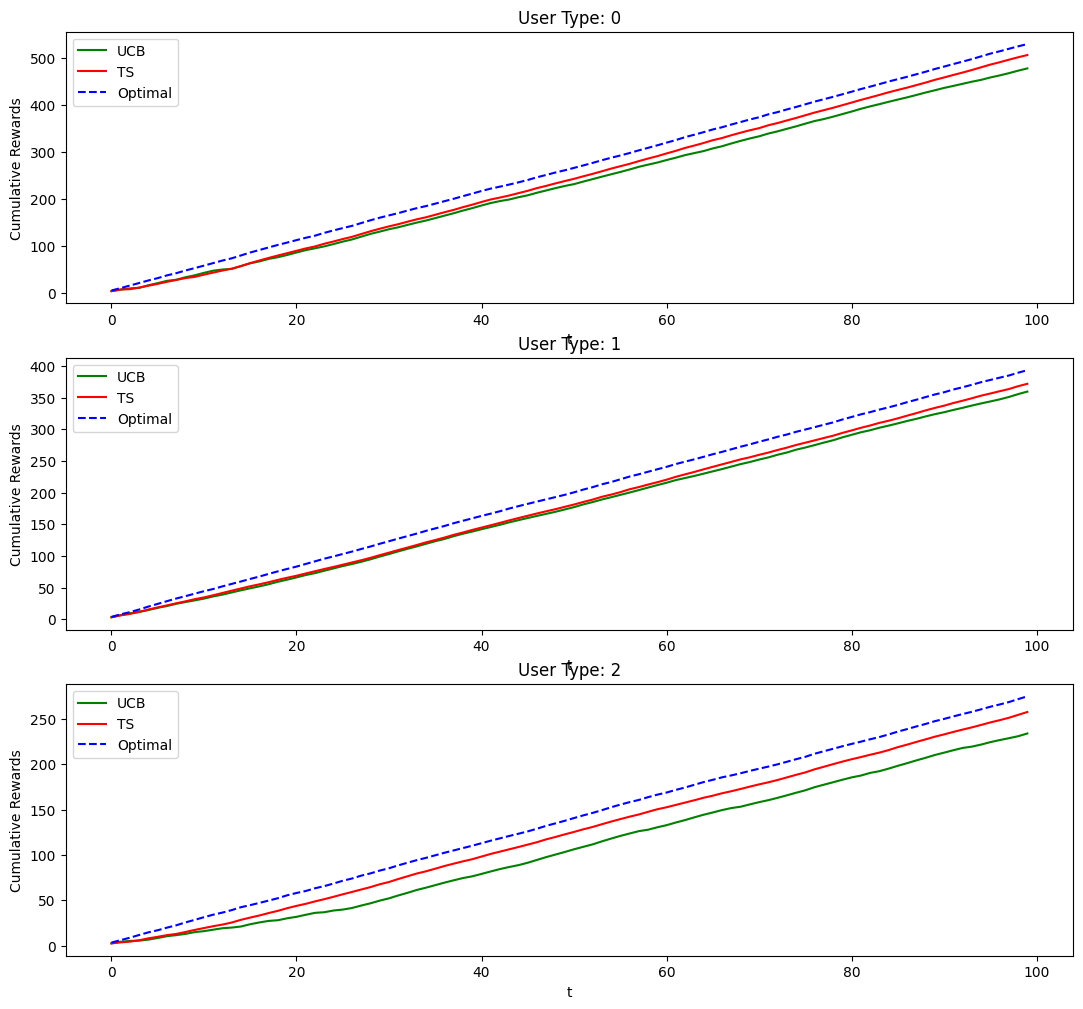

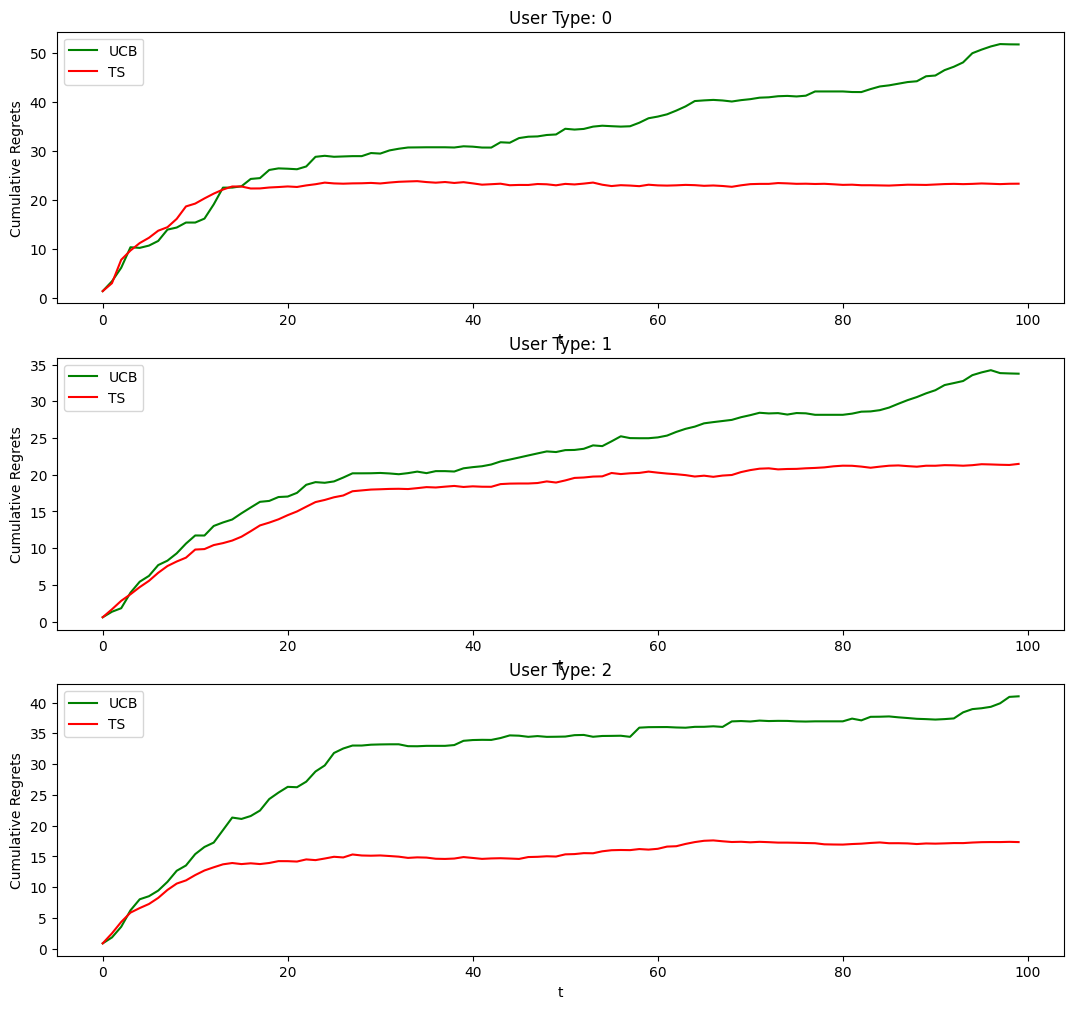

In [7]:
for user_type in range(env.n_user_types):

    fig = plt.figure(0, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    plt.title(f'User Type: {user_type}')
    plt.xlabel("t")
    plt.ylabel("Rewards")

    ucb_y = ucb_rewards[user_type]
    ts_y = ts_rewards[user_type]
    optimal_y = optimal_rewards[user_type]
    max_y = max([*ucb_y, *ts_y, *optimal_y])

    ax, = plt.plot(ucb_y, 'g')
    ax.set_label("UCB")
    ax, = plt.plot(ts_y, 'r')
    ax.set_label("TS")
    ax, = plt.plot(optimal_y, 'b--')
    ax.set_label("Optimal")

    fig = plt.figure(1, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    plt.title(f'User Type: {user_type}')
    plt.xlabel("t")
    plt.ylabel("Cumulative Rewards")

    ucb_y = np.cumsum(ucb_rewards[user_type])
    ts_y = np.cumsum(ts_rewards[user_type])
    optimal_y = np.cumsum(optimal_rewards[user_type])

    ax, = plt.plot(ucb_y, 'g')
    ax.set_label("UCB")
    ax, = plt.plot(ts_y, 'r')
    ax.set_label("TS")
    ax, = plt.plot(optimal_y, 'b--')
    ax.set_label("Optimal")

    plt.legend()

    fig = plt.figure(2, figsize=(13, 12))
    fig.add_subplot(env.n_user_types, 1, user_type + 1)
    plt.title(f'User Type: {user_type}')
    plt.xlabel("t")
    plt.ylabel("Cumulative Regrets")

    ucb_y = np.cumsum(optimal_rewards[user_type] - ucb_rewards[user_type])
    ts_y = np.cumsum(optimal_rewards[user_type] - ts_rewards[user_type])

    ax, = plt.plot(ucb_y, 'g')
    ax.set_label("UCB")
    ax, = plt.plot(ts_y, 'r')
    ax.set_label("TS")

    plt.legend()

plt.show()